In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

# ---------------------------- reproducibility ---------------------------- #
np.random.seed(42)

# ---------------------------- SIR model ---------------------------- #
def sir_equations(y, beta, gamma, mu):
    S, I, R = y
    N = 1.0
    dS_dt = mu * (N - S) - beta * S * I / N
    dI_dt = beta * S * I / N - (mu + gamma) * I
    dR_dt = gamma * I - mu * R
    return [dS_dt, dI_dt, dR_dt]

# ---------------------------- time grid ---------------------------- #
start_time = 0.0
end_time = 50.0
time_step = 0.2
t = np.arange(start_time, end_time, time_step)

# ---------------------------- solver ---------------------------- #
def eulermethod_sir(sir_equations, initial_conditions, t, params):
    x = np.asarray(initial_conditions, dtype=float)
    xs = [x]
    for k in range(t.shape[0] - 1):
        dt = t[k + 1] - t[k]
        dS, dI, dR = sir_equations(x, *params)
        x = [x[0] + dt * dS, x[1] + dt * dI, x[2] + dt * dR]
        xs.append(x)
    xs = np.asarray(xs, dtype=float)
    return xs[:, 0], xs[:, 1], xs[:, 2]

# ---------------------------- data gen + save ---------------------------- #
def generate_and_save_sir_data(
    t,
    num_simulations,
    split_ratio=0.5,
    output_dir="sir_results"
):
    # Ensure output directory exists
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Filenames inside chosen directory
    training_file = output_dir / "sir_training_data.npz"
    testing_file = output_dir / "sir_testing_data.npz"
    train_init_file = output_dir / "sir_train_initial_conditions.csv"
    test_init_file = output_dir / "sir_test_initial_conditions.csv"

    # Mean parameters
    beta_mean, gamma_mean, mu_mean = 0.9, 0.2, 0.3

    T = t.shape[0]
    data = np.empty((num_simulations, T, 3), dtype=float)  # [S, I, R]
    initial_conditions_list = []

    for i in range(num_simulations):
        beta, gamma, mu = beta_mean, gamma_mean, mu_mean

        rnd = np.random.rand(3)
        ic = (rnd / rnd.sum()).tolist()
        initial_conditions_list.append(ic)

        S, I, R = eulermethod_sir(sir_equations, ic, t, params=(beta, gamma, mu))
        data[i, :, 0] = S
        data[i, :, 1] = I
        data[i, :, 2] = R

    # Split
    num_train = int(num_simulations * split_ratio)
    train_data = data[:num_train]
    test_data = data[num_train:]
    train_initial_conditions = initial_conditions_list[:num_train]
    test_initial_conditions = initial_conditions_list[num_train:]

    # Save arrays
    np.savez(training_file, data=train_data)
    np.savez(testing_file, data=test_data)

    # Save ICs to CSV
    pd.DataFrame(train_initial_conditions, columns=["S0", "I0", "R0"]).to_csv(train_init_file, index=False)
    pd.DataFrame(test_initial_conditions, columns=["S0", "I0", "R0"]).to_csv(test_init_file, index=False)

    print(f"Saved results in: {output_dir.resolve()}")
    return train_data, test_data, train_initial_conditions, test_initial_conditions

# ---------------------------- run ---------------------------- #
if __name__ == "__main__":
    trajectories_train, trajectories_test, init_train, init_test = generate_and_save_sir_data(
        t, num_simulations=200, split_ratio=0.5, output_dir="Data"
    )



Saved results in: /Users/dujianda/Desktop/Clean_FEX/Data


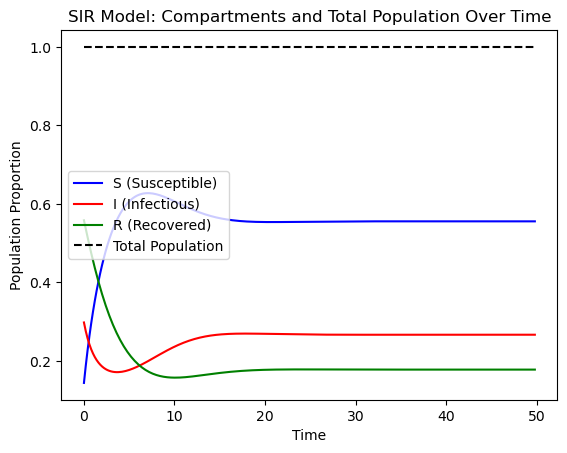

[0.14384089 0.18749694 0.2269377  0.26280023 0.29556906 0.32562178
 0.3532592  0.37872568 0.40222333 0.42392201 0.44396658 0.46248223
 0.4795784  0.49535187 0.50988898 0.52326749 0.53555794 0.54682484
 0.55712751 0.56652088 0.57505607 0.58278087 0.58974024 0.59597659
 0.60153011 0.60643904 0.61073988 0.61446757 0.61765563 0.62033635
 0.62254084 0.62429918 0.62564044 0.62659277 0.62718346 0.62743896
 0.6273849  0.6270461  0.6264466  0.62560965 0.6245577  0.62331238
 0.62189451 0.62032408 0.61862021 0.61680115 0.6148843  0.61288612
 0.61082218 0.60870714 0.60655473 0.60437774 0.60218808 0.5999967
 0.5978137  0.59564825 0.59350868 0.59140247 0.5893363  0.58731605
 0.58534685 0.58343313 0.58157862 0.57978643 0.57805905 0.57639842
 0.57480598 0.57328265 0.57182893 0.57044493 0.56913039 0.56788471
 0.56670701 0.56559616 0.56455079 0.56356935 0.5626501  0.56179118
 0.56099061 0.56024632 0.55955616 0.55891793 0.55832939 0.5577883
 0.5572924  0.55683942 0.55642714 0.55605336 0.5557159  0.555412

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved training or testing data (example: loading training data)
data = np.load('Data/sir_training_data.npz')['data']  # You can load 'seird_testing_data.npz' similarly

# Time grid (ensure this matches the one used during data generation)
t = np.arange(0, 50, 0.2)

# Select the simulation you want to plot (e.g., the first simulation, index 0)
simulation_index = 41
S = data[simulation_index, :, 0]  # Susceptible
I = data[simulation_index, :, 1]  # Infectious
R = data[simulation_index, :, 2]  # Recovered

# Calculate the total population at each time step
total_population = S + I + R

# Plot each compartment
plt.plot(t, S, label='S (Susceptible)', color='blue')
plt.plot(t, I, label='I (Infectious)', color='red')
plt.plot(t, R, label='R (Recovered)', color='green')

# Plot the total population (should be constant if N=1)
plt.plot(t, total_population, label='Total Population', color='black', linestyle='--')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Population Proportion')
plt.title('SIR Model: Compartments and Total Population Over Time')
plt.legend(loc='best')

# Show the plot
plt.show()
print(S)